In [1]:
import pandas as pd
import numpy as np

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, AutoCES, AutoTheta, Naive, SeasonalNaive
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, mse, rmse, smape

## 1) Load Data

In [2]:
import matplotlib.pyplot as plt
def plot_metrics_bar(eval_df):
    methods = eval_df.columns[1:]
    values = eval_df.iloc[0].values[1:]

    sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
    methods_sorted, values_sorted = zip(*sorted_data)

    plt.figure(figsize=(8, 5))
    bars = plt.bar(methods_sorted, values_sorted)

    for bar, value in zip(bars, values_sorted):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.xlabel('Methods')
    plt.ylabel('Mean absolute error (MAE)')
    plt.tight_layout()

    plt.show()

In [3]:
def evaluate_cv(df, metric):
    models = df.columns.drop(['unique_id', 'ds', 'y', 'cutoff']).tolist()
    evals = metric(df, models=models)
    evals['best_model'] = evals[models].idxmin(axis=1)
    return evals

In [4]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    with_best = forecasts_df.merge(evaluation_df[['unique_id', 'best_model']])
    res = with_best[['unique_id', 'ds']].copy()
    for suffix in ('', '-lo-90', '-hi-90'):
        res[f'best_model{suffix}'] = with_best.apply(lambda row: row[row['best_model'] + suffix], axis=1)
    return res

In [5]:
# Load in M4 dataset
Y_train_df = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv')
Y_test_df = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv')
Y_train_df['ds'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(Y_train_df['ds'], unit='h')
Y_test_df['ds'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(Y_test_df['ds'], unit='h')

In [6]:
# randomly select 8 series
n_series = 8
uids = Y_train_df['unique_id'].drop_duplicates().sample(8, random_state=23).values
df_train = Y_train_df.query('unique_id in @uids')
df_test = Y_test_df.query('unique_id in @uids')

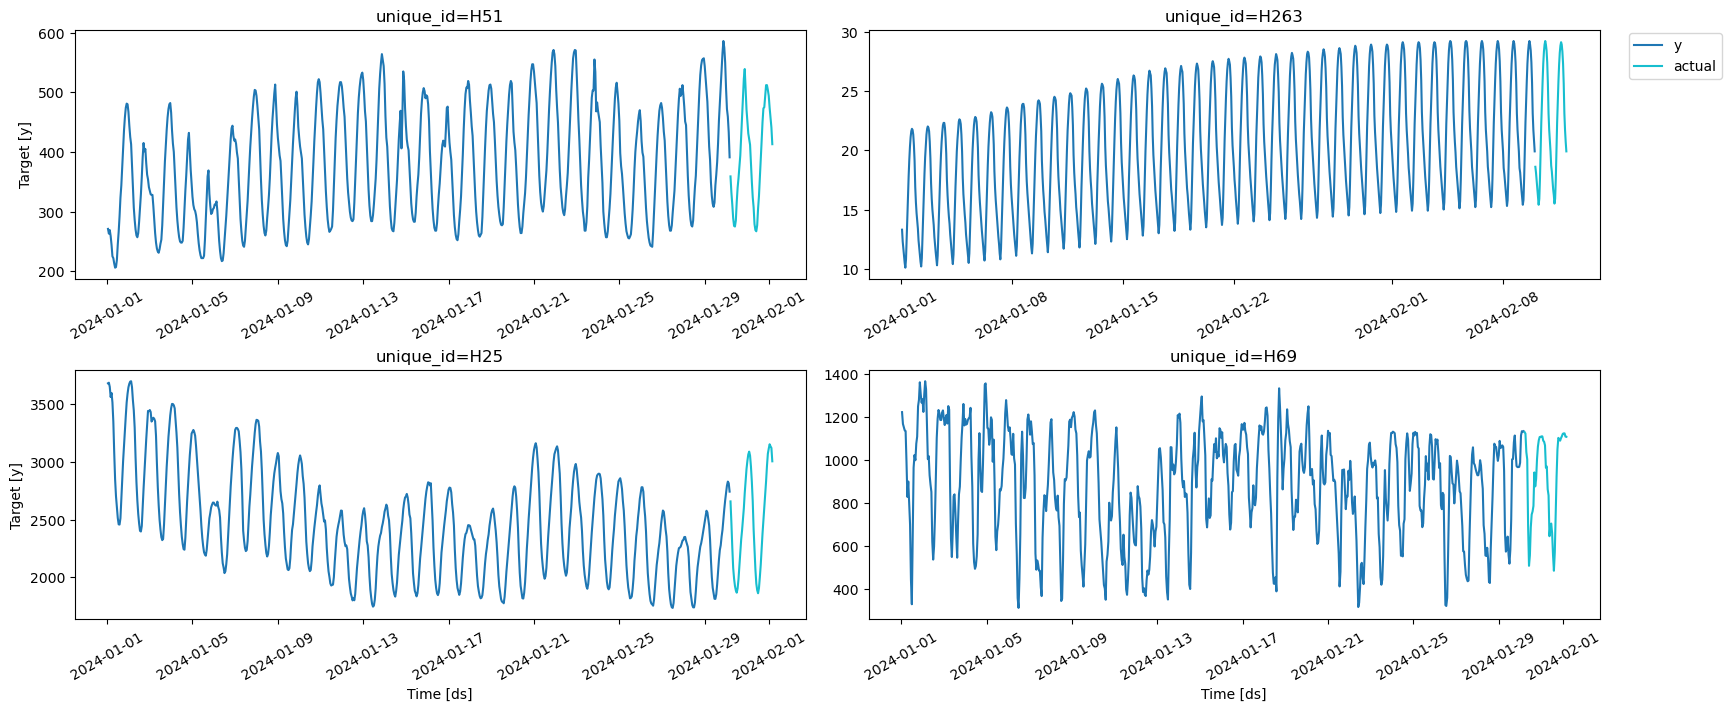

In [7]:
plot_series(df_train, df_test.rename(columns={"y": "actual"}), max_ids = 4)

In [8]:
# Use Naive and SeasonalNaive model as a baseline
sf_base = StatsForecast(
    models=[Naive(), SeasonalNaive(season_length=24)], 
    freq='H', 
    n_jobs=-1
    )

# Make baseline prediction 
fcst_base = sf_base.forecast(df = df_train, h = 48)

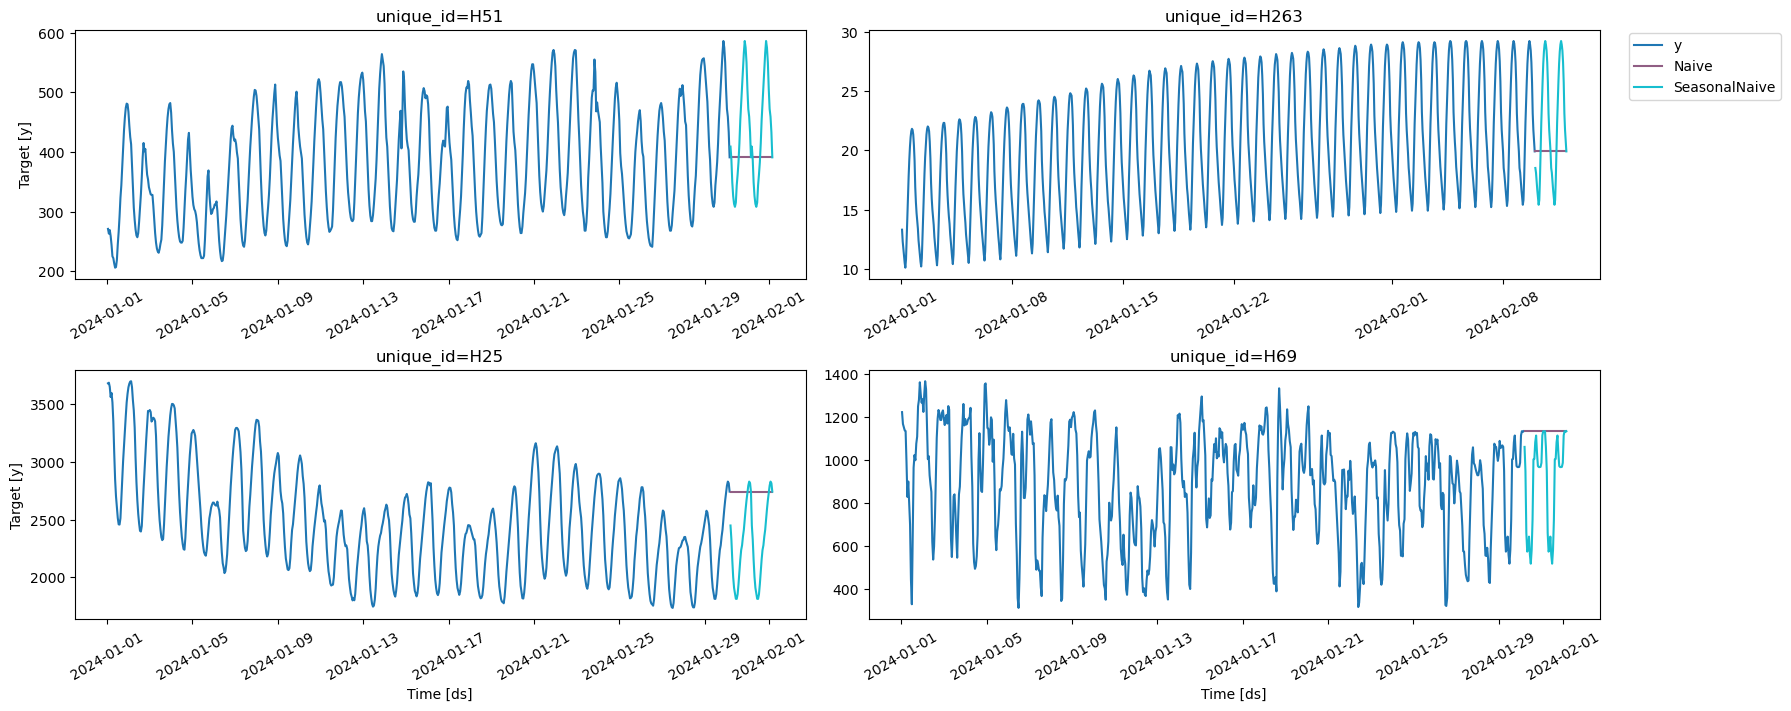

In [9]:
# Plotting the baseline result
plot_series(df_train, fcst_base, max_ids = 4)

In [10]:
# Evaluate performance 
eval_df = evaluate(
    df=df_test.merge(fcst_base, on = ['unique_id', 'ds']),
    metrics=[mae, mse, rmse, smape],
    agg_fn='mean',
).set_index('metric').T
eval_df

metric,mae,mse,rmse,smape
Naive,142.755729,68692.611615,179.520049,0.252074
SeasonalNaive,53.627083,10265.944115,66.529088,0.065754


In [11]:
# Define models
models = [
    AutoARIMA(season_length=24),
    AutoETS(season_length=24),
    AutoCES(season_length=24),
    AutoTheta(season_length=24)
]

In [12]:
# Initialize statsforecast 
sf = StatsForecast(
    models=models, 
    freq='H', 
    n_jobs=-1
    )

In [13]:
# Autofit the stats models and make prediction all in one step
fcst_sf_models = sf.forecast(df = df_train, h = 48, level=[90])
# fcst_models.head()

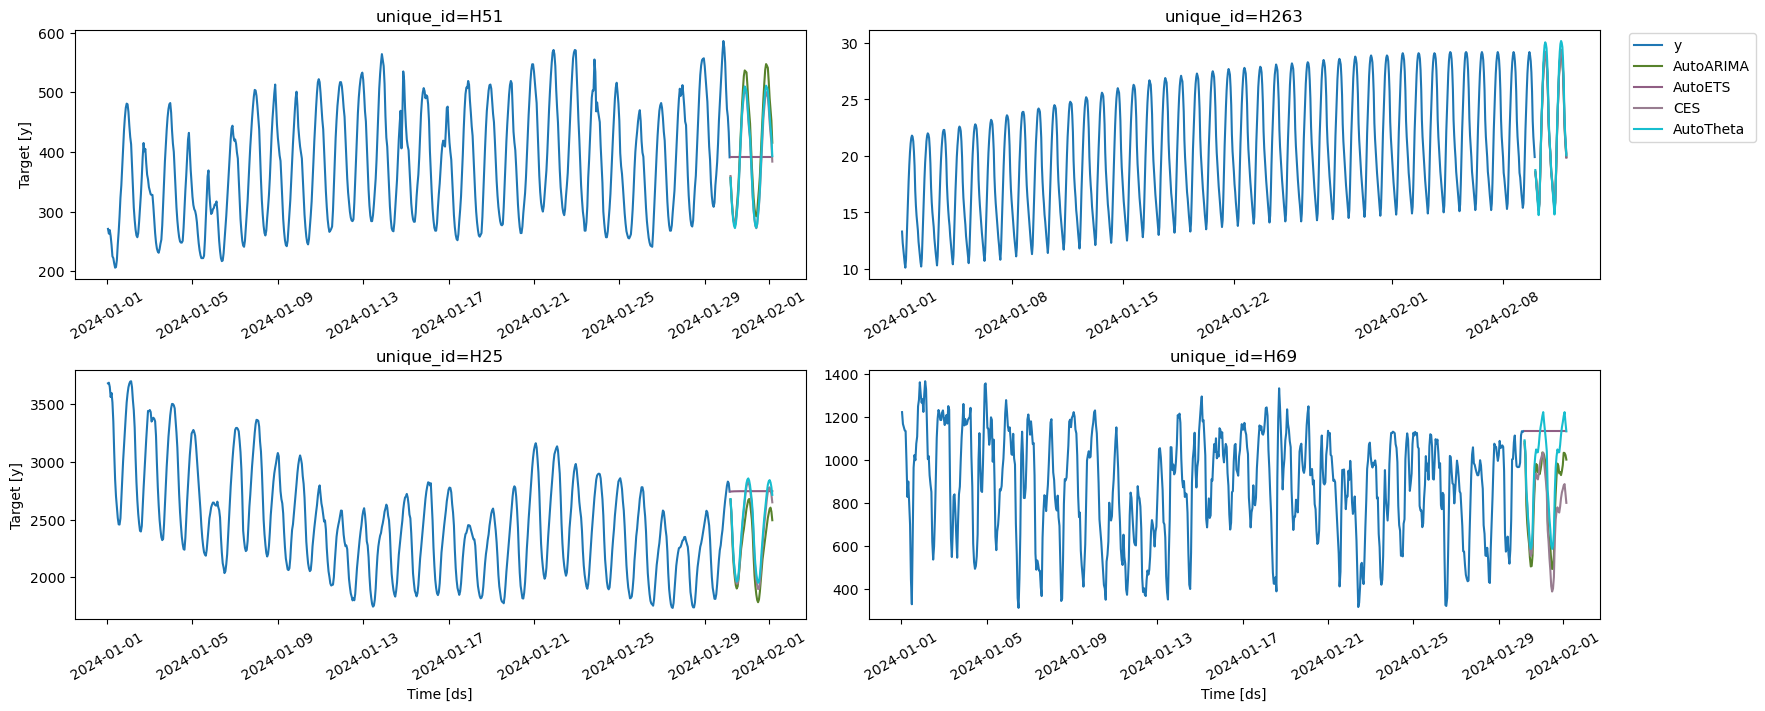

In [14]:
plot_series(df_train, fcst_sf_models, max_ids = 4)

In [15]:
eval_df_models = evaluate(
    df=df_test.merge(fcst_sf_models, on = ['unique_id', 'ds']).merge(fcst_base, on = ['unique_id', 'ds']),
    metrics=[mae, rmse, smape],
    agg_fn='mean',
).set_index('metric')
eval_df_models

,AutoARIMA,AutoETS,CES,AutoTheta,Naive,SeasonalNaive
metric,,,,,,
mae,57.180205,98.516010,49.118898,49.856542,142.755729,53.627083
rmse,71.456734,122.784231,60.979897,65.105242,179.520049,66.529088
smape,0.063307,0.075775,0.079244,0.076261,0.252074,0.065754


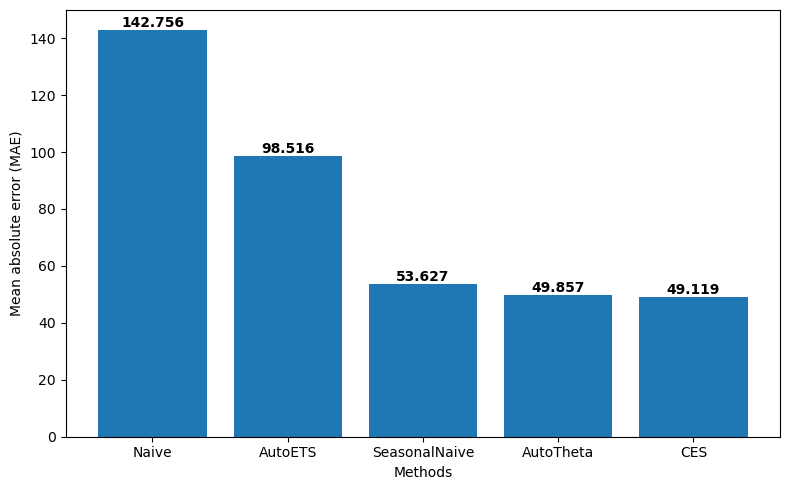

In [16]:
plot_metrics_bar(eval_df_models)

In [17]:
cv_df = sf.cross_validation(
    df=df_train,
    h=24,
    step_size=24,
    n_windows=2
)

In [18]:
evaluation_df = evaluate_cv(cv_df, mse)
evaluation_df['best_model'].value_counts().to_frame().reset_index()

,best_model,count
0,AutoARIMA,3
1,AutoETS,2
2,AutoTheta,2
3,CES,1


In [19]:
best_fcst_sf = get_best_model_forecast(fcst_sf_models, evaluation_df)

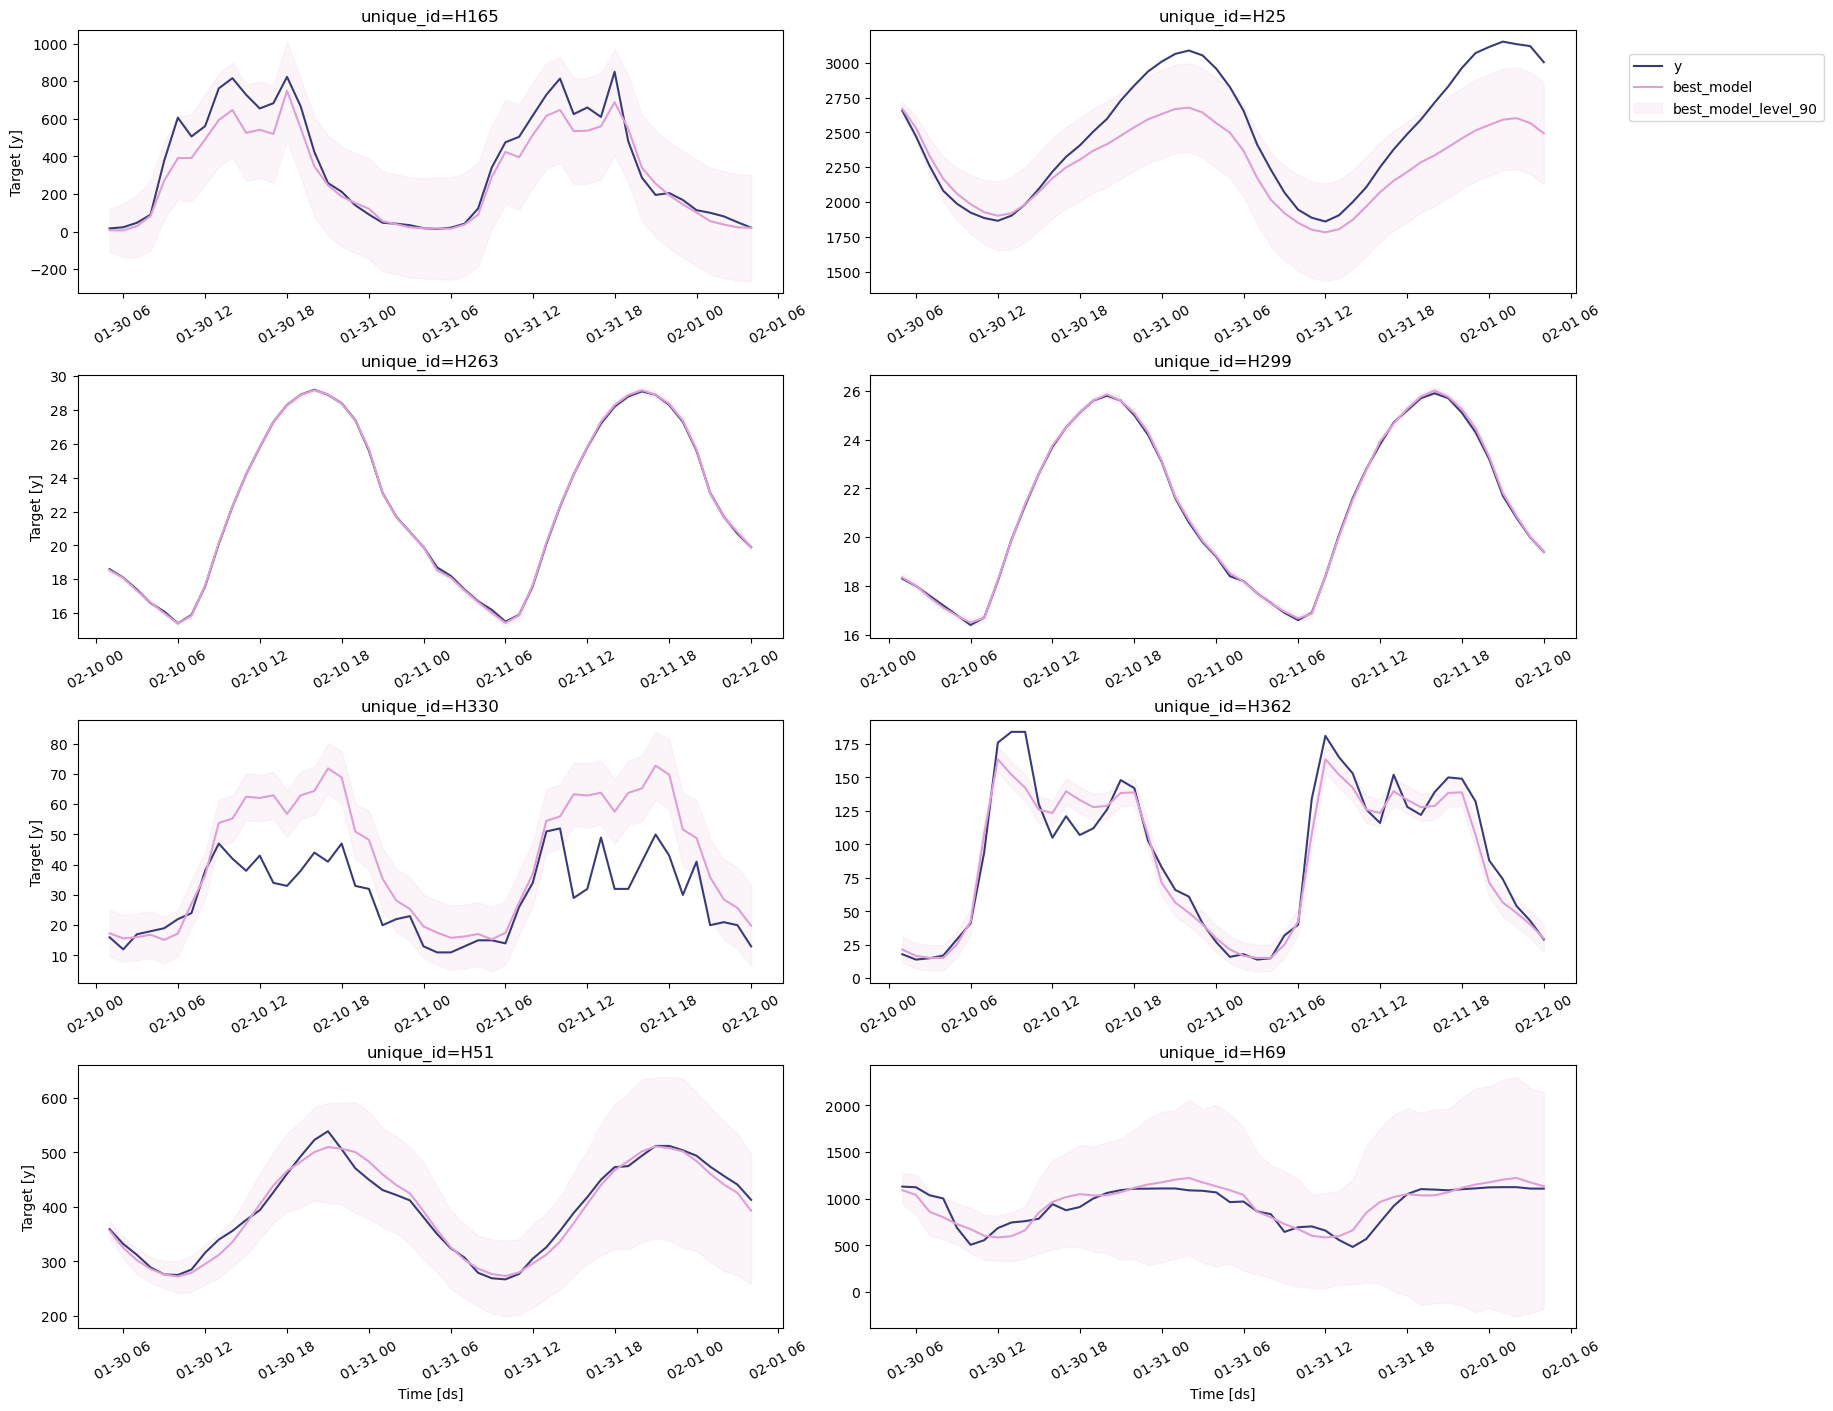

In [20]:
sf.plot(df_test, best_fcst_sf, level=[90])

In [21]:
eval_df_models = evaluate(
    df=df_test.merge(best_fcst_sf, on = ['unique_id', 'ds']),
    metrics=[mae, mse, rmse, smape],
    agg_fn='mean',
).set_index('metric')
eval_df_models

,best_model
metric,
mae,52.153005
mse,13227.573832
rmse,66.165369
smape,0.057053


In [22]:
from nixtla import NixtlaClient

nixtla_client = NixtlaClient(
    api_key='nixak-2yJ2MSMSxXNOt8MHqXkFxxtQDKFOUdW02eNwvDxMQhJJ3nPpjoDI8t7YgtyjFUVr3Qx1fdc3KkB7wGhx'
)

In [23]:
fcst_timegpt = nixtla_client.forecast(
    df=df_train,
    h=48,
    freq='H',
)
fcst_timegpt.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT
0,H165,2024-01-30 05:00:00,20.864895
1,H165,2024-01-30 06:00:00,25.422298
2,H165,2024-01-30 07:00:00,49.703796
3,H165,2024-01-30 08:00:00,134.177020
4,H165,2024-01-30 09:00:00,366.130680


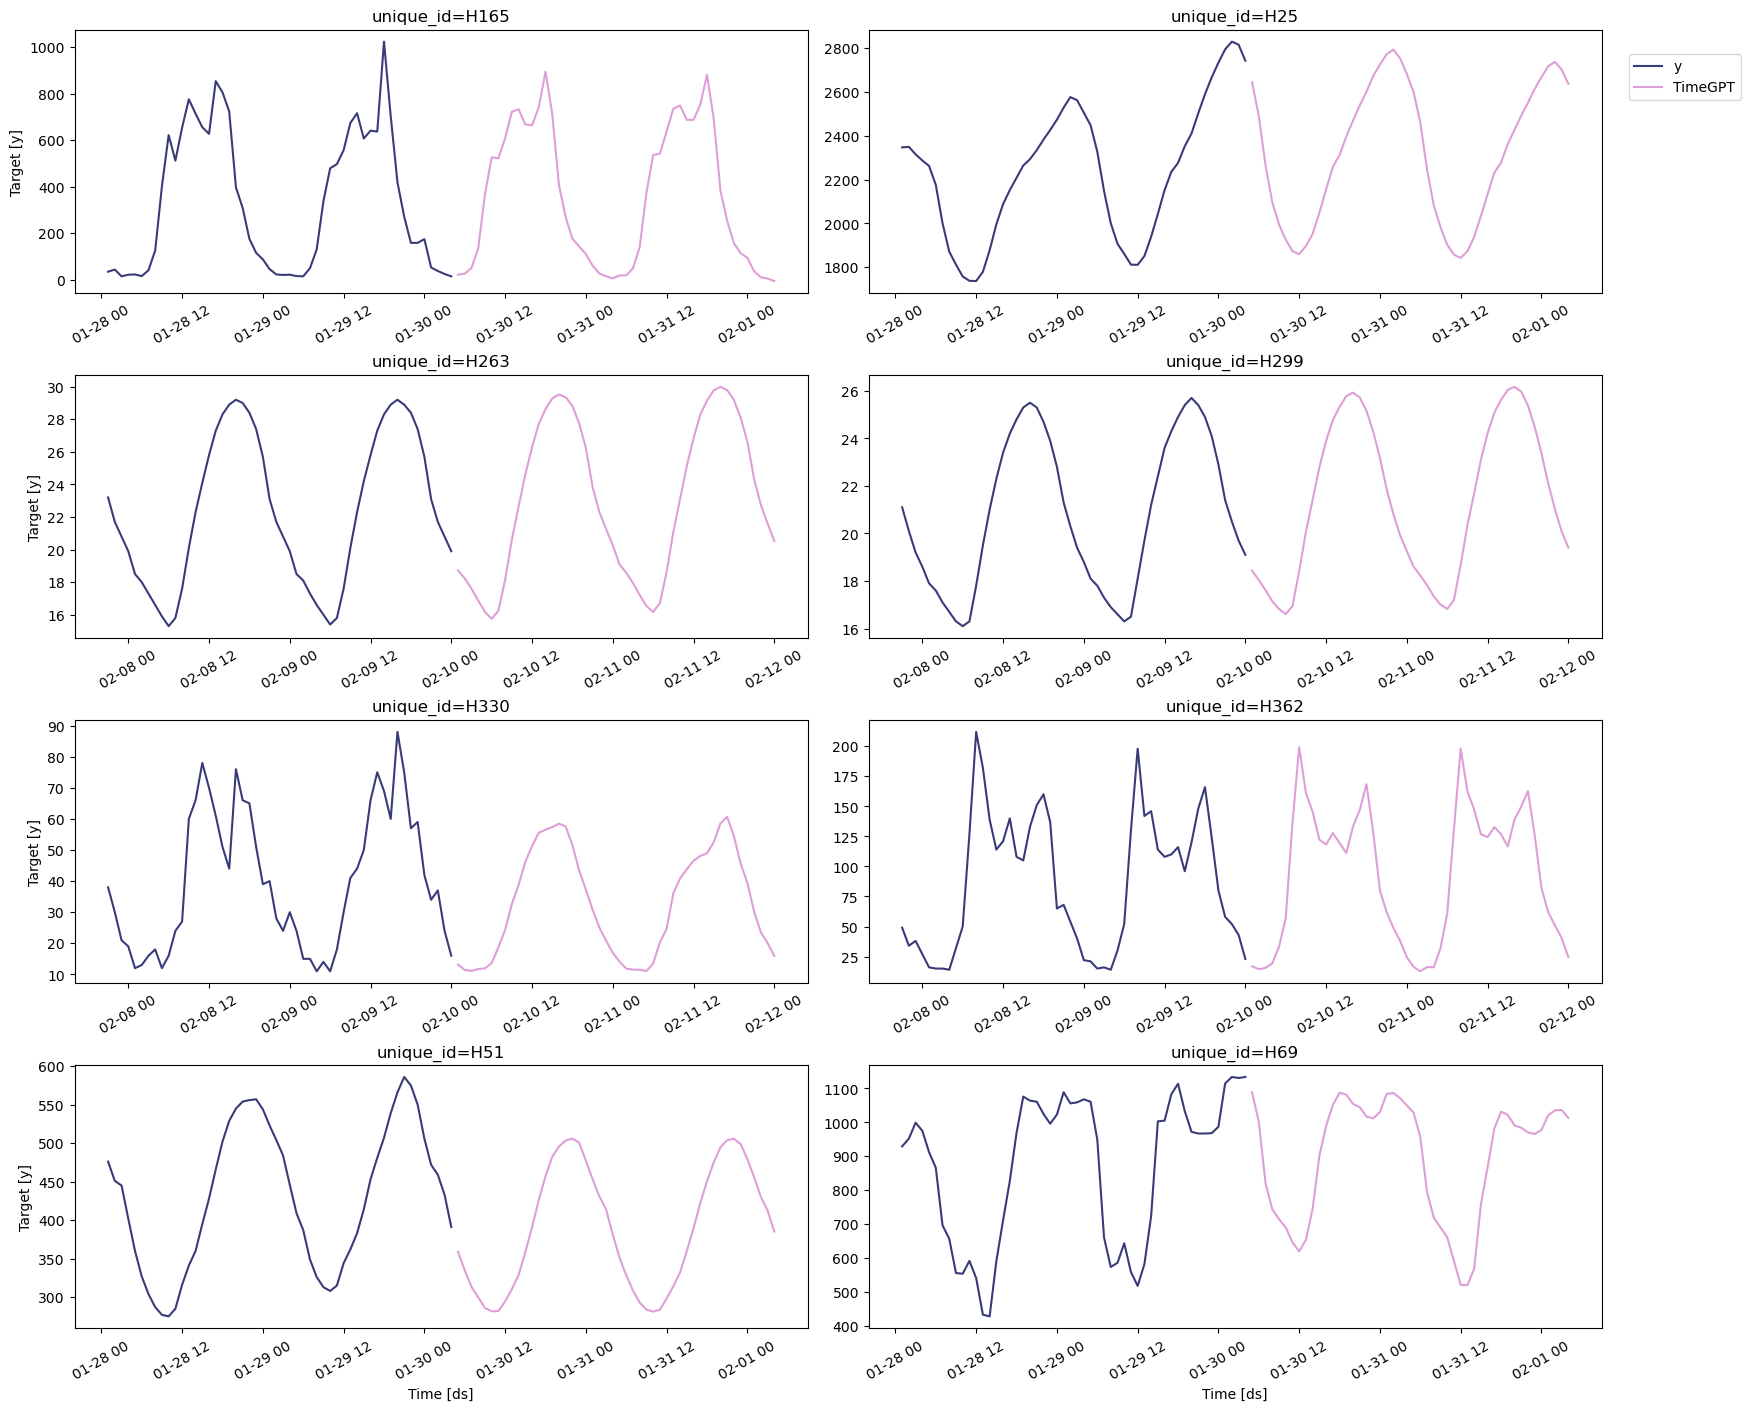

In [24]:
nixtla_client.plot(df_train, fcst_timegpt, max_insample_length=52)

In [25]:
eval_df = evaluate(
    df=df_test.merge(fcst_timegpt, on = ['unique_id', 'ds']),
    train_df=df_train,
    time_col = 'ds',
    metrics=[mae, mse, rmse, smape],
    agg_fn='mean',
).set_index('metric')
eval_df

,TimeGPT
metric,
mae,41.264709
mse,8036.436004
rmse,53.229803
smape,0.056423


In [26]:
fcst_timegpt = nixtla_client.forecast(
    df=df_train,
    h=48,
    freq='H',
    time_col = 'ds',
    finetune_steps = 100
)
fcst_timegpt.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT
0,H165,2024-01-30 05:00:00,24.124462
1,H165,2024-01-30 06:00:00,28.715818
2,H165,2024-01-30 07:00:00,57.805214
3,H165,2024-01-30 08:00:00,140.942610
4,H165,2024-01-30 09:00:00,371.788600


In [27]:
eval_df = evaluate(
    df=df_test.merge(fcst_timegpt, on = ['unique_id', 'ds']),
    train_df=df_train,
    time_col = 'ds',
    metrics=[mae, mse, rmse, smape],
    agg_fn='mean',
).set_index('metric')
eval_df

,TimeGPT
metric,
mae,40.746100
mse,6620.499401
rmse,52.092500
smape,0.067363
